## **Taller 3 - Clasificación de Géneros**
- Juan Pablo Cano - 201712395

In [1]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general

setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [22]:
!pip install -q loguru
!pip install -q -U gdown
!pip install -q tensorflow-addons
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 26.6 MB/s 


## **Importando las librerías necesarias para el taller**

In [190]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-deep")

import functools
import os
from typing import ByteString, List, Optional, Tuple, Union

import keras_tuner as kt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
import tensorflow_addons as tfa
from loguru import logger
from skimage import io
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
from tqdm.auto import tqdm

from .utils import general as gen

In [4]:
read_image = lambda x: io.imread(x)
extract_label = lambda x: "|".join(x)

In [77]:
BASE_PATH = "data/images"

In [78]:
%%shell
mkdir data/
gdown -q 1anzSoHA4J0QjfrH8oeCVjSqtTjrSmR7H -O data/movie_genre.csv

mkdir: cannot create directory ‘data/’: File exists


## **Lectura de Datos y Visualización**
- Tenemos un dataset en CSV que contiene los géneros y las URLS de cada imagen.
- La primera labor es analizar en busca de datos nulos en el dataset.

In [79]:
data = pd.read_csv("data/movie_genre.csv", encoding="ISO-8859-1")

In [80]:
data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [81]:
data.shape

(40108, 6)

In [82]:
data.columns

Index(['imdbId', 'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster'], dtype='object')

### **Limpieza y Análisis**

In [83]:
data.drop(columns=["Title", "IMDB Score", "Imdb Link"], inplace=True)
data.columns = ["id", "genre", "link"]

In [84]:
data.head()

,id,genre,link
0,114709,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


- Es necesario eliminar cualquier dato nulo asociado a la URL de la imagen o a su etiqueta. De lo contrario, el entrenamiento será imposible.

In [85]:
data = data.dropna(subset=["link", "genre"]).reset_index(drop=True)

In [86]:
data.shape

(39263, 3)

In [87]:
data.head()

,id,genre,link
0,114709,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [88]:
counts = (
    data["genre"]
    .apply(lambda x: x.split("|"))
    .explode()
    .value_counts()
    .sort_values(ascending=False)
)

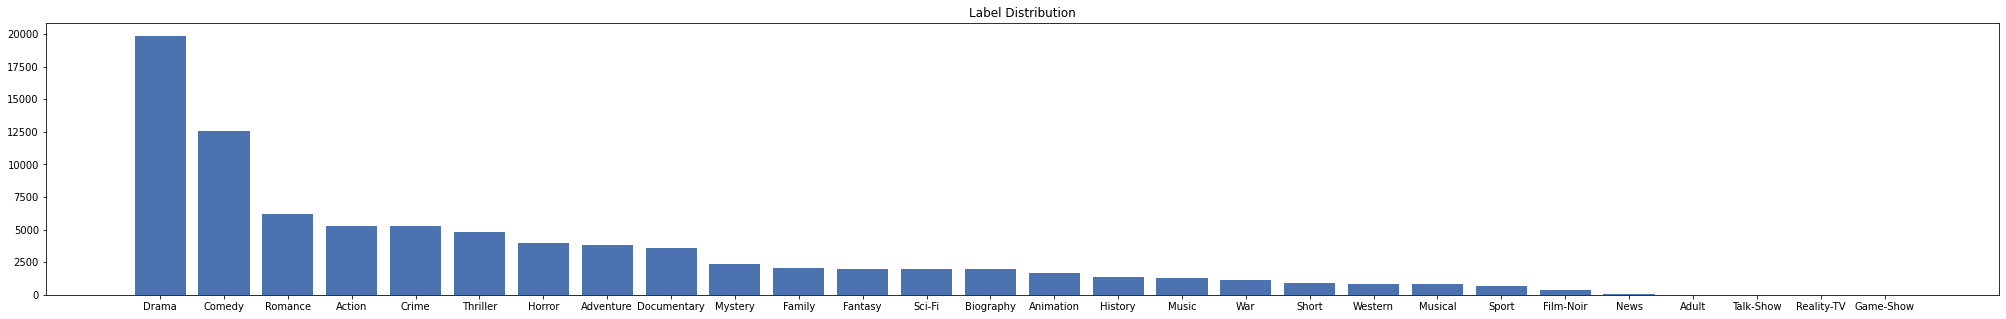

In [89]:
plt.figure(figsize=(35, 5))
plt.bar(x=counts.index, height=counts.values)
plt.title("Label Distribution")
plt.show()

- Para quitarnos el ruido de los géneros con pocas imágenes, eliminamos aquellos con menos de 1100 incidencias. Al final quedamos con 18 etiquetas.

In [90]:
labels_to_drop = counts[counts < 1100]

In [91]:
data["genre"] = data["genre"].apply(
    lambda x: [part for part in x.split("|") if part not in labels_to_drop]
)

In [92]:
data.shape

(39263, 3)

### **Descarga de los Datos**
- Procedemos a descargar los datos.

In [36]:
def get_image(link: str, file_path: str) -> bool:
    """
    Download a single image from URL.

    :param link: The link to download the image
    :param file_path: The file of the image to be stored
    :return: A flag to know if the file was, indeed, downloaded
    """
    try:
        r = requests.get(
            link,
            timeout=2,
            hooks={"response": check_response},
        )
        with open(file_path, "wb") as f:
            f.write(r.content)
        return True
    except Exception as e:
        logger.error(e)
        return False


def download_images(movies_df: pd.DataFrame, dst: str = "data") -> List[int]:
    """
    Download images from dataframe.

    :param movies_df: The dataframe with the links of the images
    :param dst: The destination directory for the images
    :return: Returns a list with the ids that were correctly downloaded
    """
    logger.info(f"Download started")

    if not os.path.exists(os.path.join(dst, "images")):
        os.makedirs(os.path.join(dst, "images"))

    correct_ids = []
    for id_, url in tqdm(movies_df[["id", "link"]].values):
        filename = os.path.join(dst, "images", f"{id_}.jpg")
        correct = get_image(url, filename)
        if correct:
            correct_ids.append(id_)

    logger.info("Download Finished")
    return correct_ids


def check_response(response: requests.Response, **kwargs) -> None:
    """
    Check response status code as hook.

    :param response: The response of the request performed
    """
    if not response.ok:
        raise RuntimeError(
            f"Error in request:\n"
            f"method: {response.request.method} - url: {response.url}\n"
            f"status code: {response.status_code}"
        )

In [39]:
correct_ids = download_images(data)

2022-04-23 19:33:15.366 | INFO     | __main__:download_images:31 - Download started


  0%|          | 0/100 [00:00<?, ?it/s]

2022-04-23 19:33:15.903 | ERROR    | __main__:get_image:20 - Error in request:
method: GET - url: https://images-na.ssl-images-amazon.com/images/M/MV5BMTUxNDYzMDY1OV5BMl5BanBnXkFtZTcwNDA2MzYxMQ@@._V1_UY268_CR2,0,182,268_AL_.jpg
status code: 404
2022-04-23 19:33:16.892 | ERROR    | __main__:get_image:20 - Error in request:
method: GET - url: https://images-na.ssl-images-amazon.com/images/M/MV5BMTIxMzA2ODk2NV5BMl5BanBnXkFtZTcwMzQ4ODIyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg
status code: 404
2022-04-23 19:33:17.163 | ERROR    | __main__:get_image:20 - Error in request:
method: GET - url: https://images-na.ssl-images-amazon.com/images/M/MV5BMTgyMzAwOTQyNF5BMl5BanBnXkFtZTcwNDU1MjgxMQ@@._V1_UY268_CR1,0,182,268_AL_.jpg
status code: 404
2022-04-23 19:33:17.672 | ERROR    | __main__:get_image:20 - Error in request:
method: GET - url: https://images-na.ssl-images-amazon.com/images/M/MV5BMTgxODIxODE2MF5BMl5BanBnXkFtZTgwOTA4NjQxMTE@._V1_UX182_CR0,0,182,268_AL_.jpg
status code: 404
2022-04-23 19:33:18.

In [41]:
data = data[data["id"].isin(correct_ids)].reset_index(drop=True)

In [ ]:
data.shape

(36424, 3)

In [93]:
data["file_path"] = data["id"].apply(lambda x: os.path.join("data", "images", f"{x}.jpg"))

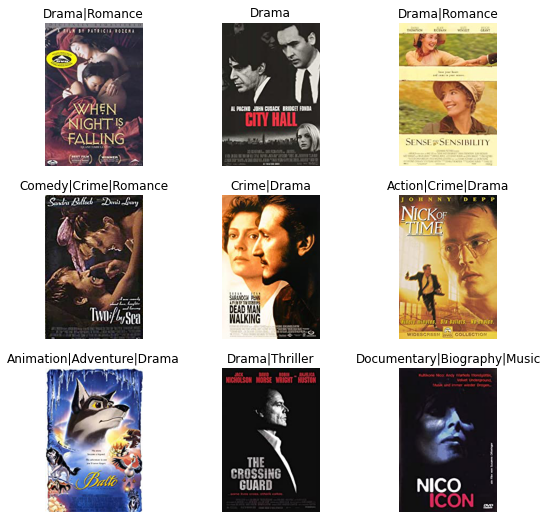

In [67]:
image_index = np.random.choice(data.index, 9)

images = list(map(read_image, data.iloc[image_index]["file_path"]))
labels = list(map(extract_label, data.iloc[image_index]["genre"]))

gen.visualize_subplot(
    imgs=images,
    titles=labels,
    division=(3, 3),
    figsize=(9, 9),
)

- Particionamos los datasets en entrenamiento, validación y testing.

In [94]:
full_X_train, X_test, full_y_train, y_test = train_test_split(
    data["file_path"].values,
    data["genre"].values,
    random_state=1234,
    test_size=0.2,
)
X_train, X_val, y_train, y_val = train_test_split(
    full_X_train, full_y_train, random_state=1234, test_size=0.2
)

In [95]:
len(X_train), len(X_val), len(X_test)

(25128, 6282, 7853)

In [96]:
mlb = MultiLabelBinarizer()
mlb.fit(data["genre"].values)

MultiLabelBinarizer()

In [97]:
len(mlb.classes_)

18

In [98]:
LABELS = mlb.classes_

In [72]:
y_train = mlb.transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

### **Almacenamiento**
- Toda la data descargada la almacenamos en TFRecords, dado que es un formato liviano y muy rápido cuando de entrenamientos se habla.

In [ ]:
def process_image(img_file: str) -> ByteString:
    """
    Process image to byte buffer.

    :param img_file: The file to be buffered
    :return: The image buffered
    """
    with open(img_file, "rb") as f:
        image_buffer = f.read()
    return image_buffer


def int64_feature(value: Union[List[int], int]) -> tf.train.Feature:
    """
    Transform integer
    to Tensorflow Feature list.

    :param value: The value to be transformed
    :return: The value transformed to TF Feature
    """
    if not isinstance(value, list):
        value = [value]

    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def bytes_feature(value: ByteString) -> tf.train.Feature:
    """
    Transform a byte string to a
    Tensorflow Feature list.

    :param value: The byte string to be transformed
    :return: The value transformed to TF Feature
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_to_example(
    image_buffer: ByteString,
    label: int,
) -> tf.train.Example:
    """
    Transform the image buffer, the
    label and the bounding box to an Example,
    which is going to be serialized in
    the TFRecord file.

    :param image_buffer: The image buffer string
    :param label: The label of the image
    :param bbox: The array of coordinates
    of the location of the class bird
    :return: The TF Example object ready to be
    Serialized in the TFRecord File
    """
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": bytes_feature(tf.compat.as_bytes(image_buffer)),
                "class": int64_feature(label),
            }
        )
    )
    return example


def create_tfrecord(
    file_collection: List[str],
    label_collection: List[int],
    tfrecord_name: str = "collection.tfrec",
) -> None:
    """
    Serialize into TFRecord file all the Tensorflow
    examples created in the file collection.

    :param file_collection: The collection of images,
    labels and bboxes to be stored
    :param tfrecord_name: The name of the TFRecord
    file to be created
    """
    with tf.io.TFRecordWriter(tfrecord_name) as writer:
        for image_filepath, label_array in tqdm(list(zip(file_collection, label_collection))):
            label_array = [int(label) for label in label_array]
            image_buffer = process_image(image_filepath)
            example = convert_to_example(image_buffer, label_array)
            writer.write(example.SerializeToString())

In [ ]:
create_tfrecord(X_train, y_train, "train.tfrec")
create_tfrecord(X_val, y_val, "val.tfrec")
create_tfrecord(X_test, y_test, "test.tfrec")

  0%|          | 0/23311 [00:00<?, ?it/s]

  0%|          | 0/5828 [00:00<?, ?it/s]

  0%|          | 0/7285 [00:00<?, ?it/s]

## **Modelado**
### **Descarga de los Datos Procesados**

In [5]:
%%shell
mkdir data
echo "Descargando data..."
echo "Entrenamiento"
gdown -q 1i9SA3FN1p6iax44BmVUrttRBh7oHH5pl -O data/train.tfrec
echo "Validación"
gdown -q 1dYFyFpWxSmkSrxkWho2KgR-jpEBP8l-m -O data/val.tfrec
echo "Testing"
gdown -q 1aASAkmHTemnwPERIH94taQ1Fr9XqXgK0 -O data/test.tfrec

Descargando data...
Entrenamiento
Validación
Testing


In [6]:
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = (23311, 5828, 7285)
BATCH_SIZE = 64
NUM_CLASSES = 18

DATA_SHAPE = (128, 128)

### **Procesamiento y Carga**

In [7]:
def parse_image_function(
    example_input: tf.Tensor,
) -> Tuple[tf.Tensor]:
    """
    Parse a TFRecord serialized single example.

    :param example_input: The serialized TF
    Example to be parsed
    :return: The resulting image and label of
    the parsed Example
    """
    # We extract the feature description from the example
    # represented by features of fixed length and fixed type
    image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([18], tf.int64),
    }

    # We parse example by example
    feature = tf.io.parse_single_example(example_input, image_feature_description)

    # We get the features from the feature dict
    image = feature["image"]
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(feature["class"], tf.int32)

    return image, label


def process_image(
    image: tf.Tensor,
    label: tf.Tensor,
) -> Tuple[tf.Tensor]:
    """
    Process the image, label and bbox.

    :param image: The image to be processed
    :param label: The label of the image
    :param bbox: The bbox of the image
    :return: The image, label and bbox processed
    """
    shape = tf.shape(image)

    image = tf.image.resize(image, DATA_SHAPE)
    # image = tf.image.rgb_to_grayscale(image)

    return image, label


def augment_data(
    img: tf.Tensor,
    label: tf.Tensor,
) -> Tuple[tf.Tensor]:
    """
    Augment data from image functions.

    :param img: The image to be processed
    :param label: The label of the image
    :return: The image processed and the label
    """
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, 0.3)

    return img, label


def performance(
    dataset: tf.data.Dataset,
    train: bool = True,
) -> tf.data.Dataset:
    """
    Function to boost dataset load performance.

    :param dataset: The dataset to be boosted
    :param train: Flag to indicate the nature of the dataset
    :return: The dataset boosted
    """
    if train:
        # Shuffle the dataset to a fixed buffer sample
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        # The number of batches that will be parallel processed
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Repeat the incidences in the dataset
    dataset = dataset.repeat()
    # Create batches from dataset
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [8]:
train_ds = tf.data.TFRecordDataset("data/train.tfrec")
val_ds = tf.data.TFRecordDataset("data/val.tfrec")
test_ds = tf.data.TFRecordDataset("data/test.tfrec")

In [9]:
train_ds = train_ds.map(parse_image_function)
val_ds = val_ds.map(parse_image_function)
test_ds = test_ds.map(parse_image_function)

In [10]:
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)
test_ds = test_ds.map(process_image)

In [11]:
train_ds = train_ds.map(augment_data)

In [12]:
for image, label in train_ds.take(5):
    tf.print("Image shape: ", image.shape)
    tf.print("Label shape: ", label.shape)
    tf.print("Label: ", label)

Image shape:  TensorShape([128, 128, 3])
Label shape:  TensorShape([18])
Label:  [0 0 0 ... 0 0 0]
Image shape:  TensorShape([128, 128, 3])
Label shape:  TensorShape([18])
Label:  [0 0 0 ... 0 1 0]
Image shape:  TensorShape([128, 128, 3])
Label shape:  TensorShape([18])
Label:  [1 0 0 ... 1 0 0]
Image shape:  TensorShape([128, 128, 3])
Label shape:  TensorShape([18])
Label:  [0 1 0 ... 0 0 0]
Image shape:  TensorShape([128, 128, 3])
Label shape:  TensorShape([18])
Label:  [0 0 0 ... 0 0 0]


In [13]:
train_ds = performance(train_ds)
val_ds = performance(val_ds, False)
test_ds = performance(test_ds, False)

In [14]:
for img_batch, label_batch in train_ds.take(1):
    tf.print(img_batch.shape)
    tf.print(label_batch.shape)

TensorShape([64, 128, 128, 3])
TensorShape([64, 18])


### **Creación de Métrica y Función de Pérdida**
- En este caso usamos una métrica global, la F1. Esta la necesitamos puesto que nos ayuda a ponderar de forma global el resultado con respecto a los verdaderos postivos, falsos positivos y falsos negativos. La F1 es útil en este caso porque tenemos una predicción para cada etiqueta, en lugar de una única predicción.

In [15]:
class MacroSoftF1(keras.losses.Loss):
    def __init__(
        self,
        name: str = "MacroSoftF1",
        epsilon: float = 1e-16,
        **kwargs,
    ) -> None:
        """
        Initializer function.

        :param name: The name of the loss function
        :param epsilon: The epsilon softener
        """
        super(MacroSoftF1, self).__init__(name=name, **kwargs)
        self.epsilon = epsilon

    def call(
        self,
        y_true: tf.Tensor,
        y_pred: tf.Tensor,
    ) -> tf.Tensor:
        """
        Loss function caller.

        :param y_true: The true labels
        :param y_pred: The predicted labels
        """
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        # True positives
        tp = tf.reduce_sum(y_pred * y_true, axis=0)
        # False positives
        fp = tf.reduce_sum(y_pred * (1 - y_true), axis=0)
        # False negatives
        fn = tf.reduce_sum((1 - y_pred) * y_true, axis=0)
        # Soft f1 calculated
        soft_f1 = 2 * tp / (2 * tp + fn + fp + self.epsilon)
        cost = 1 - soft_f1
        macro_cost = tf.reduce_mean(cost)
        return macro_cost


class MacroF1(keras.metrics.Metric):
    def __init__(
        self,
        name: str = "MacroF1",
        thresh: float = 0.5,
        epsilon: float = 1e-16,
        **kwargs,
    ) -> None:
        """
        Initializer function.

        :param name: The name of the metric
        :param thresh: The threshold of the scores
        :param epsilon: The epsilon softener
        """
        super(MacroF1, self).__init__(name=name, **kwargs)
        self.batch_macro_f1 = self.add_weight(
            name="macro_f1",
            initializer="zeros",
        )
        self.count = self.add_weight(
            name="count",
            initializer="zeros",
        )
        self.thresh = thresh
        self.epsilon = epsilon

    def update_state(
        self,
        y_true: tf.Tensor,
        y_pred: tf.Tensor,
        sample_weight: Optional[tf.Tensor] = None,
    ) -> tf.Tensor:
        """
        Update the metric weights.

        :param y_true: The true labels
        :param y_pred: The predicted labels
        :param sample_weight: Optional weighting of each example
        """
        y_pred_temp = tf.cast(tf.greater(y_pred, self.thresh), tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.cast(tf.math.count_nonzero(y_pred_temp * y_true, axis=0), tf.float32)
        fp = tf.cast(
            tf.math.count_nonzero(y_pred_temp * (1 - y_true), axis=0),
            tf.float32,
        )
        fn = tf.cast(
            tf.math.count_nonzero((1 - y_pred_temp) * y_true, axis=0),
            tf.float32,
        )
        f1 = 2 * tp / (2 * tp + fn + fp + self.epsilon)
        macro_f1 = tf.reduce_mean(f1)
        self.batch_macro_f1.assign_add(macro_f1)
        self.count.assign_add(1)

    def result(self) -> tf.Tensor:
        """
        Calculate the result of weights.
        """
        return self.batch_macro_f1 / self.count

In [16]:
Dense = functools.partial(keras.layers.Dense, activation="relu")

- La arquitectura utilizada es el Perceptrón Multicapa, por lo que, necesitamos convertir nuestras imágenes a vectores.
- En la capa final usamos una capa densa con 18 neuronas, cada una asociada a cada etiqueta, y una activación sigmoide. La activación sigmoide se hace porque buscamos una predicción entre 0 y 1 para cada género de película, dado que estamos en un contexto multietiqueta, en lugar de que la sumatoria de todas las predicciones sea igual a 1, lo que nos indica que habrá un único género que tendrá predominancia sobre el resto.

In [27]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(*DATA_SHAPE, 3)),
        keras.layers.Flatten(),
        Dense(1024),
        Dense(512),
        Dense(256),
        Dense(128),
        Dense(64),
        Dense(32),
        keras.layers.Dense(NUM_CLASSES, activation="sigmoid"),
    ]
)

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[
        tfa.metrics.F1Score(
            num_classes=NUM_CLASSES,
            average="macro",
            threshold=0.5,
        )
    ],
    loss=MacroSoftF1(),
)

In [29]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 5,
    "validation_data": val_ds,
}

In [43]:
model.fit(train_ds, **params)

Epoch 1/5
364/364 [==============================] - 39s 105ms/step - loss: 0.8042 - f1_score: 0.2015 - val_loss: 0.8061 - val_f1_score: 0.1983
Epoch 2/5
364/364 [==============================] - 24s 66ms/step - loss: 0.8023 - f1_score: 0.2027 - val_loss: 0.8030 - val_f1_score: 0.2018
Epoch 3/5
364/364 [==============================] - 24s 66ms/step - loss: 0.8013 - f1_score: 0.2039 - val_loss: 0.8021 - val_f1_score: 0.2029
Epoch 4/5
364/364 [==============================] - 26s 71ms/step - loss: 0.8001 - f1_score: 0.2048 - val_loss: 0.8017 - val_f1_score: 0.2029
Epoch 5/5
364/364 [==============================] - 24s 66ms/step - loss: 0.8006 - f1_score: 0.2044 - val_loss: 0.8017 - val_f1_score: 0.2025


In [21]:
model.evaluate(test_ds, steps=TEST_SIZE // BATCH_SIZE)

113/113 [==============================] - 5s 43ms/step - loss: 0.8000 - f1_score: 0.2052


[0.8000324368476868, 0.20519715547561646]

## **Optimización de Hiperparámetros**
- En esta ocasión vamos a tunear la función de activación y el inicializador del kernel.

In [70]:
def model_builder(hyperparameters: kt.HyperParameters) -> keras.Model:
    """
    Build model for hyperparameter tuning.

    :param hyperparameters: The hyperparameter container
    for the hyperparameter space
    :return: The model with the hyperparameters
    """
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(*DATA_SHAPE, 3)))
    model.add(keras.layers.Flatten())
    for units in range(10, 4, -1):
        model.add(
            keras.layers.Dense(
                2 ** units,
                activation=hyperparameters.Choice(
                    "activation",
                    ["relu", "softplus", "swish"],
                ),
                kernel_initializer=hyperparameters.Choice(
                    "kernel_initializer",
                    ["glorot_normal", "he_normal"],
                ),
            ),
        )
    model.add(keras.layers.Dense(NUM_CLASSES, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        metrics=[
            tfa.metrics.F1Score(
                num_classes=NUM_CLASSES,
                average="macro",
                threshold=0.5,
            )
        ],
        loss=MacroSoftF1(),
    )
    return model

In [72]:
tuner = kt.RandomSearch(
    model_builder,
    objective=kt.Objective("val_f1_score", direction="max"),
    seed=1234,
    max_trials=10,
)

In [73]:
params["epochs"] = 10

In [74]:
with tf.device("/device:GPU:0"):
    tuner.search(
        train_ds,
        **params,
    )

Trial 6 Complete [00h 05m 22s]
val_f1_score: 0.19766558706760406

Best val_f1_score So Far: 0.21545515954494476
Total elapsed time: 00h 29m 27s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]

In [76]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 1024)              50332672  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2

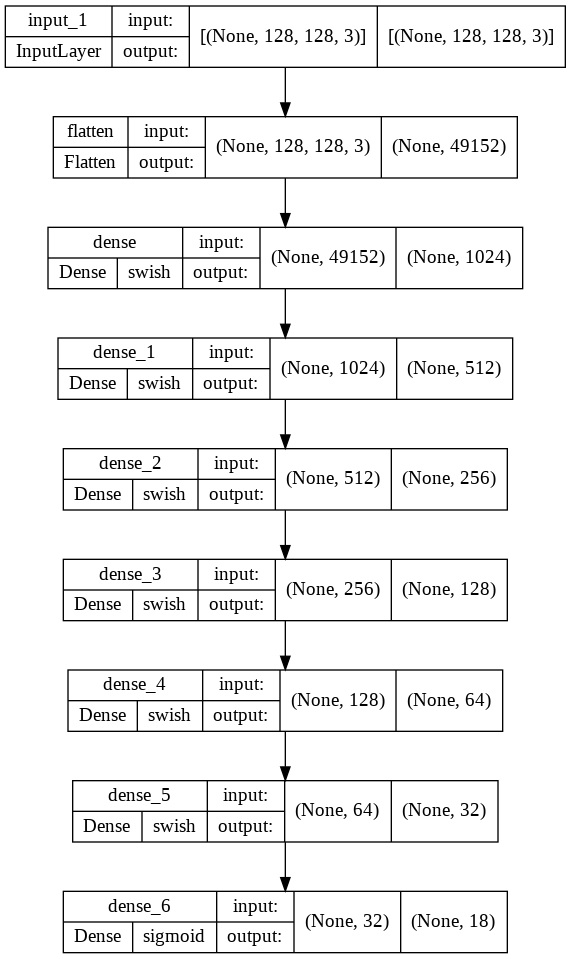

In [101]:
keras.utils.plot_model(
    best_model,
    show_layer_activations=True,
    show_shapes=True,
)

In [173]:
params["epochs"] = 50

- Hacemos un pequeño reentrenamiento de nuestro mejor modelo para ver cuáles son los mejores resultados que se pueden obtener.

In [174]:
best_model.fit(train_ds, **params)

Epoch 1/50
364/364 [==============================] - 35s 90ms/step - loss: 0.7940 - f1_score: 0.2125 - val_loss: 0.8000 - val_f1_score: 0.2054
Epoch 2/50
364/364 [==============================] - 27s 73ms/step - loss: 0.7923 - f1_score: 0.2143 - val_loss: 0.7924 - val_f1_score: 0.2137
Epoch 3/50
364/364 [==============================] - 27s 74ms/step - loss: 0.7913 - f1_score: 0.2145 - val_loss: 0.7915 - val_f1_score: 0.2136
Epoch 4/50
364/364 [==============================] - 28s 75ms/step - loss: 0.7897 - f1_score: 0.2168 - val_loss: 0.7922 - val_f1_score: 0.2138
Epoch 5/50
364/364 [==============================] - 27s 73ms/step - loss: 0.7894 - f1_score: 0.2166 - val_loss: 0.7938 - val_f1_score: 0.2114
Epoch 6/50
364/364 [==============================] - 26s 72ms/step - loss: 0.7896 - f1_score: 0.2156 - val_loss: 0.7923 - val_f1_score: 0.2130
Epoch 7/50
364/364 [==============================] - 27s 73ms/step - loss: 0.7893 - f1_score: 0.2174 - val_loss: 0.7951 - val_f1_score:

## **Validación**
- una vez hecho el entrenamiento procedemos a validar nuestros resultados contra lo que tenemos en testing.

In [175]:
best_model.evaluate(test_ds, steps=TEST_SIZE // BATCH_SIZE)

113/113 [==============================] - 5s 44ms/step - loss: 0.7895 - f1_score: 0.2191


[0.7895044088363647, 0.21914003789424896]

In [176]:
for X_batch, y_batch in test_ds.take(1):
    ...

In [177]:
y_batch_pred = best_model.predict(X_batch)

In [178]:
X_batch = X_batch.numpy()
y_batch = y_batch.numpy()

In [179]:
array_to_label = lambda x: LABELS[x]

In [180]:
indexes = np.random.randint(0, 64, size=9)

X = X_batch[indexes]
y_true = list(
    map(
        extract_label,
        list(map(array_to_label, y_batch[indexes].astype(bool))),
    ),
)
y_pred = list(
    map(
        extract_label,
        list(map(array_to_label, y_batch_pred[indexes] > 0.8)),
    ),
)
titles = [f"True: {t} \n Pred: {p}" for t, p in list(zip(y_true, y_pred))]

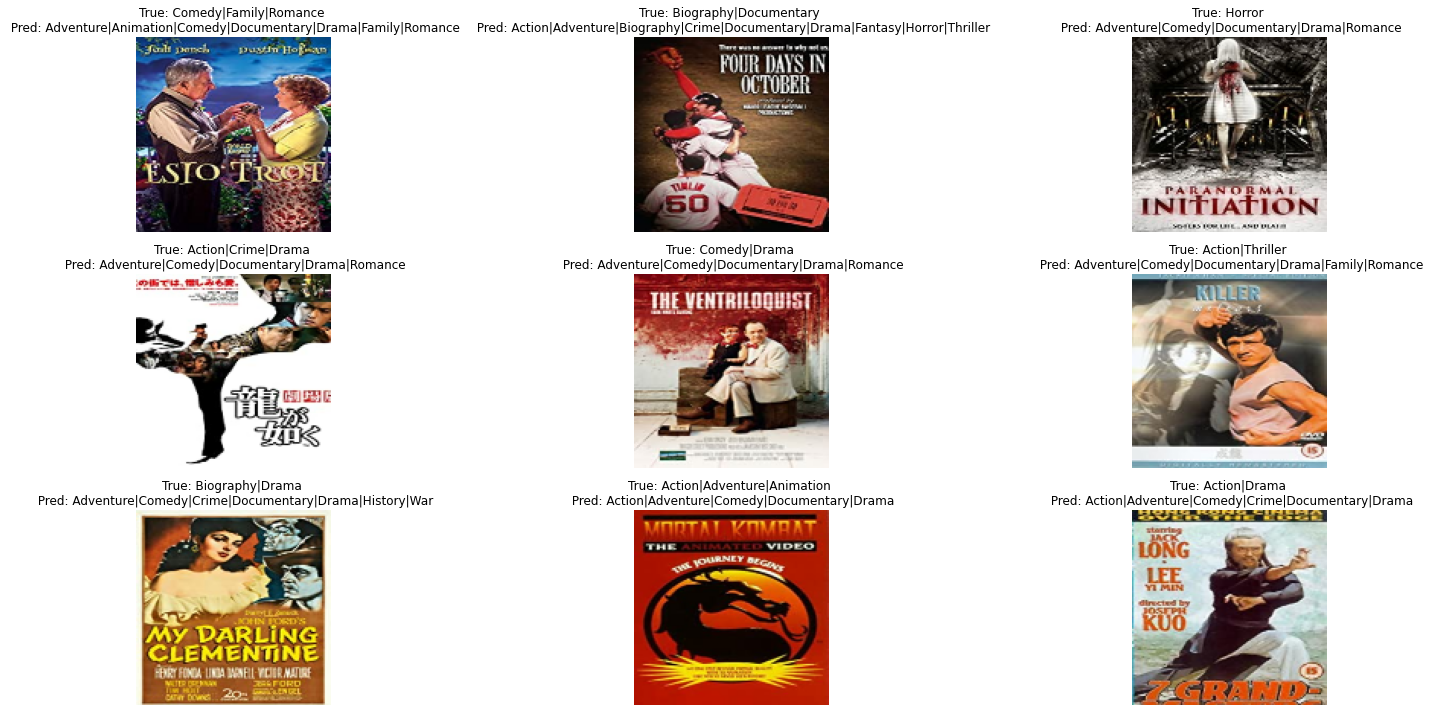

In [182]:
gen.visualize_subplot(
    imgs=X,
    titles=titles,
    division=(3, 3),
    figsize=(20, 10),
)
plt.tight_layout()

In [193]:
print(classification_report(y_batch, y_batch_pred > 0.8))

              precision    recall  f1-score   support

           0       0.31      0.67      0.42        12
           1       0.16      1.00      0.27        10
           2       0.00      0.00      0.00         1
           3       0.04      0.25      0.07         4
           4       0.33      0.88      0.48        16
           5       0.07      0.29      0.11         7
           6       0.09      1.00      0.17         6
           7       0.58      1.00      0.73        37
           8       0.14      0.33      0.20         3
           9       0.00      0.00      0.00         5
          10       0.25      0.50      0.33         2
          11       0.08      0.14      0.11         7
          12       0.00      0.00      0.00         0
          13       0.14      0.29      0.19         7
          14       0.13      0.40      0.20        10
          15       0.10      0.33      0.15         3
          16       0.06      0.14      0.09         7
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Conclusiones**
- El modelo tuvo un rendimiento bajo puesto que es un perceptrón que trabaja con imágenes. Por lo tanto, al convertirlas en vectores perdemos la percepción espacial de cada imagen y eso no ayuda a que las predicciones sean de buena calidad. Por otra parte, si se hiciera uso de una función descriptora de imágen, daría mejores resultados al final.
- De cara al negocio, vemos que nuestro modelo logra predecir varios géneros por cada póster de película, aunque lo hace con poca precisión. Para un futuro proyecto, sería ideal probar arquitecturas neuronales más orientadas al análisis de imágen, como la red neuronal convolucional.